# Regular activity test

In [2]:
import invalid_sample_detection    as invalid
import load_annotations            as annotate
import matplotlib.pyplot           as plt
import numpy                       as np
import parameters
import wfdb
import math

%matplotlib inline
%config IPCompleter.greedy=True

## RR intervals tests

In [16]:
# Check if standard deviation of RR intervals of signal are within limits
def check_rr_stdev(rr_intervals): 
    numpy_rr_intervals = np.array(rr_intervals)
    stdev = np.std(numpy_rr_intervals)
    if stdev > parameters.RR_STDEV: 
        return False
    return True

# Check if heart rate, calculated by number of RR intervals in signal, are within limits
def check_heart_rate(rr_intervals, alarm_duration): 
    hr = len(rr_intervals) / float(alarm_duration) * parameters.NUM_SECS_IN_MIN
        
    if hr > parameters.HR_MAX or hr < parameters.HR_MIN: 
        return False
    return True

# Check if sum of RR intervals is within limit of total duration, to ensure beats are evenly spaced throughout
def check_sum_rr_intervals(rr_intervals, alarm_duration): 
    min_sum = alarm_duration - parameters.RR_MIN_SUM_DIFF
        
    rr_sum = sum(rr_intervals)
    if rr_sum < min_sum: 
        return False
    return True    

# Check if total number of RR intervals is greater than a minimum 
def check_num_rr_intervals(rr_intervals): 
    if len(rr_intervals) < parameters.MIN_NUM_RR_INTERVALS: 
        return False
    return True

## Invalids tests

In [4]:
# Returns False if any block within signal is identified as invalid (invalid sample detection)
def check_invalids(invalids, channel): 
    if channel not in invalids.keys(): 
        raise Exception("Unknown channel")
    
    block_invalids_sum = sum(invalids[channel])
    if block_invalids_sum > parameters.INVALIDS_SUM: 
        return False
    return True

## Putting it all together

In [5]:
# Returns type of alarm and whether gold standard classified alarm as true or false
def check_gold_standard_classification(fields): 
    alarm_type, alarm_classification = fields['comments']
    
    if "True" in alarm_classification: 
        is_true_alarm = True
    else:
        is_true_alarm = False
        
    return alarm_type, is_true_alarm

# Get start and end points (in sample number) to check depending on type of alarm signaled
def get_start_and_end(data_path, sample_name): 
    sig, fields = wfdb.rdsamp(data_path + sample_name)

    alarm_type = fields['comments'][0]
    if alarm_type not in parameters.TESTED_BLOCK_LENGTHS: 
        raise Exception("Unrecognized alarm type")
    tested_block_length = parameters.TESTED_BLOCK_LENGTHS[alarm_type]
    
    end = parameters.ALARM_TIME # in seconds, alarm always sounded at 300th second
    start = end - tested_block_length # in seconds
    
    return (start, end, tested_block_length)

# Get annotation file type based on channel type and index
def get_ann_type(channel, channel_index, ecg_ann_type): 
    channel_type = invalid.get_channel_type(channel)

    if channel_type == "ECG": 
        ann_type = ecg_ann_type + str(channel_index)
    elif channel_type == "ABP": 
        ann_type = 'wabp'
    else:  
        ann_type = "wpleth"
    
    return ann_type

# Check if our classification matches with gold standard classification of true/false alarm nature
def is_classified_correctly(is_true_alarm, is_regular): 
    is_classified_true_alarm = not is_regular
    matches = is_true_alarm is is_classified_true_alarm
    if matches: 
        return "\nMatches! Alarm was a " + str(is_true_alarm) + " alarm"
    else:
        return "\n" + str(is_true_alarm) + " alarm classified as a " + str(is_classified_true_alarm).lower() + " alarm"

In [35]:
# Returns True for a given channel if all regular activity tests to be checked pass
def check_interval_regular_activity(rr_intervals, invalids, alarm_duration, channel,
                                    should_check_invalids, should_check_rr): 
    if len(rr_intervals) == 0: 
        return False
    
    all_checks = np.array([])
    if should_check_invalids: 
        invalids_check = check_invalids(invalids, channel)
        all_checks = np.append(all_checks, invalids_check)
    
    if should_check_rr: 
        stdev_check = check_rr_stdev(rr_intervals)
        hr_check = check_heart_rate(rr_intervals, alarm_duration)
        sum_check = check_sum_rr_intervals(rr_intervals, alarm_duration)
        num_check = check_num_rr_intervals(rr_intervals)
        
        all_checks = np.append(all_checks, [stdev_check, hr_check, sum_check, num_check])
    
    return np.all(all_checks)


# Check each channel for regular activity. If any channel exhibits regular activity, alarm indicated as false alarm
# Start and end given in seconds.
def check_channel_regular_activity(data_path, ann_path, sample_name, ecg_ann_type, start, end, alarm_duration,
                                   should_check_invalids, should_check_rr): 
    sig, fields = wfdb.rdsamp(data_path + sample_name)
    
    channels = fields['signame']
    num_channels = len(channels)
    fs = fields['fs']
        
    invalids = invalid.calculate_invalids(data_path + sample_name, start, end)

    for channel_index in range(num_channels): 
        channel = channels[channel_index]
        channel_type = invalid.get_channel_type(channel)
        channel_should_check_rr = should_check_rr
        
        # Ignore respiratory channel
        if channel == "RESP": 
            continue
        ann_type = get_ann_type(channel, channel_index, ecg_ann_type)
        
        try: 
            channel_rr_intervals = annotate.calculate_rr_intervals(ann_path + sample_name, ann_type,
                                                                   start, end, channel_type)
        except Exception as e: 
            channel_rr_intervals = []
            channel_should_check_rr = False
            print e
            
        is_regular = check_interval_regular_activity(channel_rr_intervals, invalids, alarm_duration, channel,
                                                     should_check_invalids, channel_should_check_rr)
                
        # If any channel exhibits regular activity, deem signal as regular activity
        if is_regular: 
            return True
    return False

In [7]:
# Check if overall sample exhibits regular activity or not (with RR and/or invalids checks)
def is_sample_regular(data_path, ann_path, sample_name, ecg_ann_type, 
                      should_check_invalids=True, should_check_rr=True): 
    
    start, end, alarm_duration = get_start_and_end(data_path, sample_name)    
    is_regular = check_channel_regular_activity(data_path, ann_path, sample_name, ecg_ann_type, start, end, 
                                                alarm_duration, should_check_invalids, should_check_rr)
    return is_regular

[Errno 2] No such file or directory: 'sample_data/challenge_training_multiann/t208s.jqrs1'

Matches! Alarm was a True alarm


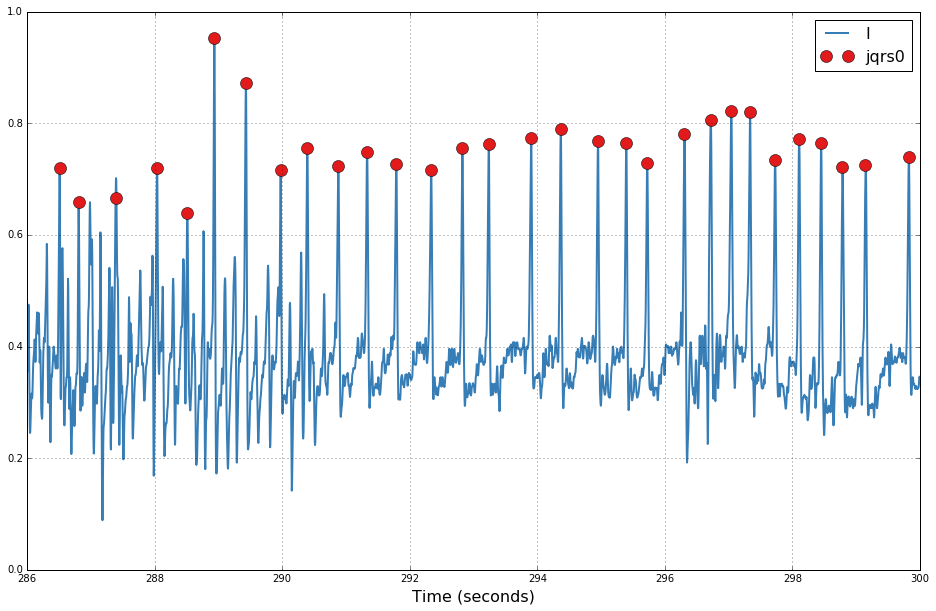

In [36]:
if __name__ == '__main__': 
    data_path = 'sample_data/challenge_training_data/'
    ann_path = 'sample_data/challenge_training_multiann/'
    sample_name = 't208s'
    ecg_ann_type = 'jqrs'
        
    sig, fields = wfdb.rdsamp(data_path + sample_name)
    alarm_type, is_true_alarm = check_gold_standard_classification(fields)
    start, end, alarm_duration = get_start_and_end(data_path, sample_name)    
        
    is_regular = is_sample_regular(data_path, ann_path, sample_name, ecg_ann_type)
    
    print is_classified_correctly(is_true_alarm, is_regular)
    
    annotate.plot_annotations(data_path, ann_path, sample_name, ['jqrs0'], 0, fields['fs'], start, end)